In [3]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge
# from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, max_error
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer



In [4]:
mbd = pd.read_csv("MBD_CFIP_20monthlag.csv")

# Dropping rows from CFIPS #28055 which contains values of 0, in order to calculate SMAPE
mbd = mbd.drop(mbd[mbd["CFIP"]==28055].index)
mbd = mbd.to_numpy()

In [5]:
# train/test split
X = mbd[:,2:-1]
y = mbd[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# SMAPE method for evaluation
def smape(y_test, y_pred):
    numerator = np.abs(y_test-y_pred)
    denominator = (y_test + np.abs(y_pred)) /200
    return np.mean(np.divide(numerator,denominator))

gs_smape = make_scorer(smape, greater_is_better=False)

## Core algorithm - Linear Regression

In [31]:
# linear regression
regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.8f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.8f" % r2_score(y_test, y_pred))
# The SMAPE
print("SMAPE: %.8f" % smape(y_test, y_pred))

Coefficients: 
 [-8.11233736e-03  7.82530741e-04  1.45637591e-02  8.55830140e-01
 -8.23285392e-01 -2.33825041e-03  1.04753178e-02 -8.91073783e-02
  3.31735126e-02 -1.09070745e-03  1.53199216e-02 -2.39708676e-02
 -3.50060223e-02  2.55126897e-02 -2.86659450e-03  3.03596329e-02
 -7.18634911e-02  1.04116097e-01 -1.47989350e-02  9.88816403e-01]
Mean squared error: 0.13935522
Coefficient of determination: 0.99646098
SMAPE: 2.79810986


### Fine-tuning with normalization techniques: Ridge (L2) and Lasso(L1) normalization

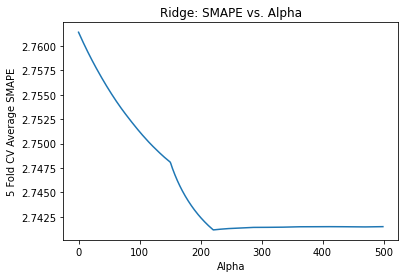

Best alpha value: 221.0


In [34]:
# Grid search to find optimal values of alpha



ridge_alpha_values = np.arange(0.00,500,1)
param_grid = {'alpha': ridge_alpha_values}

gs_ridge = GridSearchCV(Ridge(), 
                        param_grid, 
                        scoring = gs_smape,
                        cv = 5)
gs_ridge.fit(X_train,y_train)

# Extract alpha values and corresponding SMAPE scores
alphas = gs_ridge.cv_results_['param_alpha'].data.astype(float)
smape_scores = -gs_ridge.cv_results_['mean_test_score']

# Plot the SMAPE scores vs. alpha values
plt.plot(alphas, smape_scores)
plt.xlabel('Alpha')
plt.ylabel('5 Fold CV Average SMAPE')
plt.title('Ridge: SMAPE vs. Alpha')
plt.show()

print("Best alpha value:", gs_ridge.best_params_['alpha'])


In [25]:
# Ridge with optimal alpha

ridge = Ridge(alpha = gs_ridge.best_params_['alpha'])
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
print("Coefficients: \n", ridge.coef_)
# The mean squared error
print("Mean squared error: %.8f" % mean_squared_error(y_test, y_pred_ridge))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.8f" % r2_score(y_test, y_pred_ridge))
# The SMAPE
print("SMAPE: %.8f" % smape(y_test, y_pred_ridge))

Coefficients: 
 [-8.54496473e-03  3.07866694e-03  1.78962410e-02  8.39919951e-01
 -8.00179207e-01 -1.37022411e-02  8.75959211e-03 -8.76928133e-02
  3.10734739e-02  1.91209849e-04  1.48617661e-02 -2.43325485e-02
 -3.40872319e-02  2.40374274e-02 -1.51853579e-03  2.91084736e-02
 -7.02656134e-02  1.04290356e-01 -6.38652912e-03  9.79754922e-01]
Mean squared error: 0.14239075
Coefficient of determination: 0.99638389
SMAPE: 2.77741508


C:\Users\codyt\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.066e+02, tolerance: 1.011e+02
  model = cd_fast.enet_coordinate_descent(


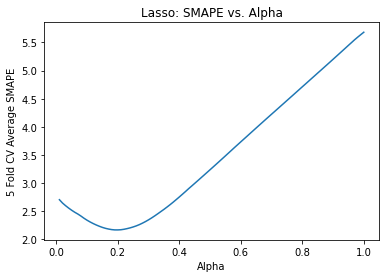

Best alpha value: 0.2


In [35]:

lasso_alpha_values = np.arange(0.01,1.01,0.01)
param_grid = {'alpha': lasso_alpha_values}
gs_lasso = GridSearchCV(Lasso(), 
                        param_grid, 
                        scoring = gs_smape,
                        cv = 5)
gs_lasso.fit(X_train,y_train)

# Extract alpha values and corresponding SMAPE scores
alphas = gs_lasso.cv_results_['param_alpha'].data.astype(float)
smape_scores = -gs_lasso.cv_results_['mean_test_score']

# Plot the SMAPE scores vs. alpha values
plt.plot(alphas, smape_scores)
plt.xlabel('Alpha')
plt.ylabel('5 Fold CV Average SMAPE')
plt.title('Lasso: SMAPE vs. Alpha')
plt.show()

print("Best alpha value:", gs_lasso.best_params_['alpha'])

In [67]:
# Lasso with optimal alpha

lasso = Lasso(alpha = gs_lasso.best_params_['alpha'])
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
print("Coefficients: \n", lasso.coef_)
# The mean squared error
print("Mean squared error: %.8f" % mean_squared_error(y_test, y_pred_lasso))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.8f" % r2_score(y_test, y_pred_lasso))
# The SMAPE
print("SMAPE: %.8f" % smape(y_test, y_pred_lasso))

Coefficients: 
 [ 0.00000000e+00  0.00000000e+00  3.42234939e-04  3.49601491e-01
 -3.04675374e-01 -0.00000000e+00 -0.00000000e+00 -2.70158939e-02
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  9.76989462e-01]
Mean squared error: 0.12130300
Coefficient of determination: 0.99691943
SMAPE: 2.20190962


In [53]:
# kernel

# kern = KernelRidge(alpha=0.5)
# kern.fit(X_train, y_train)
# y_pred_kernel = kern.predict(X_test)


# # The mean squared error
# print("Mean squared error: %.8f" % mean_squared_error(y_test, y_pred_kernel))
# # The coefficient of determination: 1 is perfect prediction
# print("Coefficient of determination: %.8f" % r2_score(y_test, y_pred_kernel))
# # The SMAPE
# print("SMAPE: %.8f" % smape(y_test, y_pred_kernel))

Mean squared error: 0.13945667
Coefficient of determination: 0.99645840
SMAPE: 2.77427250


In [10]:
# gradient boosting regressor

gbr = HistGradientBoostingRegressor()
gbr.fit(X_train,y_train)
y_pred_gbr = gbr.predict(X_test)

# The SMAPE
print("SMAPE: %.8f" % smape(y_test, y_pred_gbr))

SMAPE: 6.55835026


Best parameters: {'learning_rate': 0.11500000000000002, 'loss': 'absolute_error'}


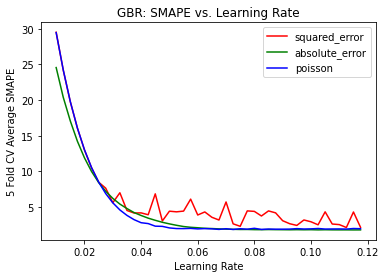

In [36]:
param_grid = {'loss':['squared_error', 'absolute_error', 'poisson'], 
              'learning_rate':np.arange(0.01,0.12,0.0025)}
gs_gbr2 = GridSearchCV(HistGradientBoostingRegressor(), 
                        param_grid,                 
                        scoring = gs_smape,
                        cv = 5)
gs_gbr2.fit(X_train,y_train)

learning_rates = gs_gbr2.cv_results_['param_learning_rate'].data
loss_values = gs_gbr2.cv_results_['param_loss'].data
mean_test_scores = -gs_gbr2.cv_results_['mean_test_score']

# Create a color map for different loss values
color_map = {
    'squared_error': 'red',
    'absolute_error': 'green',
    'poisson': 'blue'
}

for loss in param_grid['loss']:
    mask = (loss_values == loss)
    plt.plot(learning_rates[mask], mean_test_scores[mask], color=color_map[loss], label=loss)


# Set plot labels and title
plt.xlabel('Learning Rate')
plt.ylabel('5 Fold CV Average SMAPE')
plt.title('GBR: SMAPE vs. Learning Rate')

# Add a legend to the plot
plt.legend()


print("Best parameters:", gs_gbr2.best_params_)

In [7]:
# gradient boosting regressor with best parameters

#gbr = HistGradientBoostingRegressor(loss = gs_gbr2.best_params_['loss'], 
#                                   learning_rate = gs_gbr2.best_params_['learning_rate'])

gbr = HistGradientBoostingRegressor(loss = 'absolute_error', 
                                    learning_rate = 0.1125)


gbr.fit(X_train,y_train)
y_pred_gbr = gbr.predict(X_test)

# The SMAPE
print("SMAPE: %.8f" % smape(y_test, y_pred_gbr))

SMAPE: 1.75739195


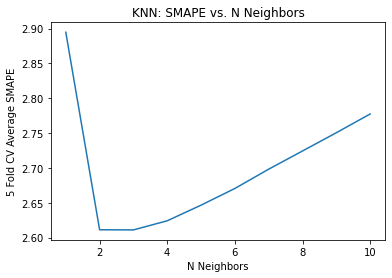

Best alpha value: {'n_neighbors': 3}


In [37]:

gs_knn = GridSearchCV(KNeighborsRegressor(), 
                      {'n_neighbors':np.arange(1,10.1,1).astype(int)},
                      scoring = gs_smape,
                      cv = 5)
gs_knn.fit(X_train, y_train)

params = gs_knn.cv_results_['param_n_neighbors'].data
smape_scores = -gs_knn.cv_results_['mean_test_score']

# Plot the SMAPE scores vs. alpha values
plt.plot(params, smape_scores)
plt.xlabel('N Neighbors')
plt.ylabel('5 Fold CV Average SMAPE')
plt.title('KNN: SMAPE vs. N Neighbors')
plt.show()

print("Best alpha value:", gs_knn.best_params_)


In [6]:


# knn regressor
knn = KNeighborsRegressor(n_neighbors=gs_knn.best_params_['n_neighbors'])
knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_test)

# The SMAPE
print("SMAPE: %.8f" % smape(y_test, y_pred_knn))

SMAPE: 2.54817179


In [12]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Normalize the input data
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the input data into a 3D array [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])


Epoch 1/100
1332/1332 [==============================] - 8s 3ms/step - loss: 24.4968 - val_loss: 22.6498
Epoch 2/100
1332/1332 [==============================] - 4s 3ms/step - loss: 12.9135 - val_loss: 19.5427
Epoch 3/100
1332/1332 [==============================] - 3s 3ms/step - loss: 10.8210 - val_loss: 17.5026
Epoch 4/100
1332/1332 [==============================] - 4s 3ms/step - loss: 9.1376 - val_loss: 15.7790
Epoch 5/100
1332/1332 [==============================] - 3s 3ms/step - loss: 7.7979 - val_loss: 14.3372
Epoch 6/100
1332/1332 [==============================] - 4s 3ms/step - loss: 6.8188 - val_loss: 13.2225
Epoch 7/100
1332/1332 [==============================] - 3s 3ms/step - loss: 6.0326 - val_loss: 12.2038
Epoch 8/100
1332/1332 [==============================] - 3s 3ms/step - loss: 5.3970 - val_loss: 11.3514
Epoch 9/100
1332/1332 [==============================] - 3s 3ms/step - loss: 4.8859 - val_loss: 10.6276
Epoch 10/100
1332/1332 [==============================] - 3s 

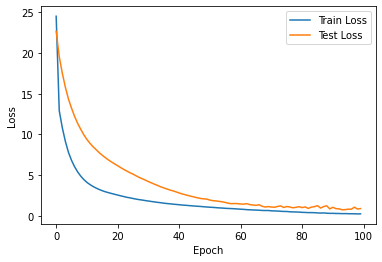

In [13]:
# Create the LSTM model
model = Sequential()
model.add(LSTM(32, input_shape=(1, 20)))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model and track loss history
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Plot the train and test loss over epochs
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
# Make predictions
y_pred_LSTM = model.predict(X_test)

# Reshape the predictions
y_pred_LSTM = y_pred_LSTM.reshape(y_pred_LSTM.shape[0])

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(np.mean((y_pred_LSTM - y_test) ** 2))
print("RMSE:", rmse)
print("SMAPE: %.8f" % smape(y_test, y_pred_LSTM))

333/333 [==============================] - 0s 1ms/step
RMSE: 0.9523384662936855
SMAPE: 6.30099984


Epoch 1/100
1332/1332 [==============================] - 8s 3ms/step - loss: 28.0163 - val_loss: 24.1103
Epoch 2/100
1332/1332 [==============================] - 4s 3ms/step - loss: 18.8002 - val_loss: 21.0627
Epoch 3/100
1332/1332 [==============================] - 4s 3ms/step - loss: 17.5923 - val_loss: 19.3225
Epoch 4/100
1332/1332 [==============================] - 4s 3ms/step - loss: 16.0771 - val_loss: 17.9671
Epoch 5/100
1332/1332 [==============================] - 4s 3ms/step - loss: 15.4751 - val_loss: 16.7177
Epoch 6/100
1332/1332 [==============================] - 4s 3ms/step - loss: 14.0326 - val_loss: 15.5399
Epoch 7/100
1332/1332 [==============================] - 4s 3ms/step - loss: 13.5984 - val_loss: 15.0628
Epoch 8/100
1332/1332 [==============================] - 4s 3ms/step - loss: 12.2724 - val_loss: 13.9865
Epoch 9/100
1332/1332 [==============================] - 4s 3ms/step - loss: 12.4904 - val_loss: 13.4415
Epoch 10/100
1332/1332 [==============================]

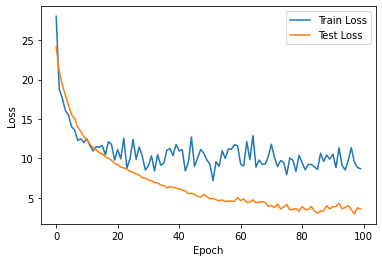

333/333 [==============================] - 1s 1ms/step
SMAPE: 24.55574696


In [15]:
# LSTM with different layers

model2 = Sequential()
model2.add(LSTM(32, input_shape=(1,20)))
model2.add(Dense(1))
model2.add(Dropout(0.2, input_shape=(1,20)))
model2.compile(loss='mean_squared_error', optimizer='adam')
history2 = model2.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))
# Plot the train and test loss over epochs
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
y_pred_LSTM2 = model2.predict(X_test)
y_pred_LSTM2 = y_pred_LSTM2.reshape(y_pred_LSTM2.shape[0])
print("SMAPE: %.8f" % smape(y_test, y_pred_LSTM2))

Epoch 1/100
1332/1332 [==============================] - 13s 5ms/step - loss: 19.9287 - val_loss: 22.1809
Epoch 2/100
1332/1332 [==============================] - 5s 4ms/step - loss: 13.0892 - val_loss: 19.6513
Epoch 3/100
1332/1332 [==============================] - 5s 4ms/step - loss: 11.1137 - val_loss: 17.6910
Epoch 4/100
1332/1332 [==============================] - 6s 4ms/step - loss: 9.6153 - val_loss: 16.1991
Epoch 5/100
1332/1332 [==============================] - 6s 4ms/step - loss: 8.3856 - val_loss: 14.9636
Epoch 6/100
1332/1332 [==============================] - 6s 4ms/step - loss: 7.4292 - val_loss: 13.8315
Epoch 7/100
1332/1332 [==============================] - 6s 4ms/step - loss: 6.5269 - val_loss: 12.8810
Epoch 8/100
1332/1332 [==============================] - 6s 4ms/step - loss: 5.9979 - val_loss: 12.0707
Epoch 9/100
1332/1332 [==============================] - 6s 4ms/step - loss: 5.6217 - val_loss: 11.3225
Epoch 10/100
1332/1332 [==============================] - 6s

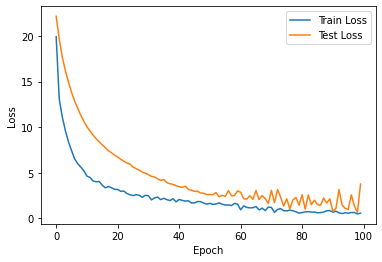

333/333 [==============================] - 2s 2ms/step
SMAPE: 3.52890675


In [16]:
# LSTM with multiple LSTM & Dropouts
model3 = Sequential()
model3.add(LSTM(32, input_shape=(1,20), return_sequences=True))
model3.add(Dropout(0.2, input_shape=(1,20)))
model3.add(LSTM(32))
model3.add(Dropout(0.2, input_shape=(1,20)))
model3.add(Dense(1))

model3.compile(loss='mean_squared_error', optimizer='adam')
history3 = model3.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))
# Plot the train and test loss over epochs
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

y_pred_LSTM3 = model3.predict(X_test)
y_pred_LSTM3 = y_pred_LSTM3.reshape(y_pred_LSTM3.shape[0])
print("SMAPE: %.8f" % smape(y_test, y_pred_LSTM3))

Epoch 1/100
1332/1332 [==============================] - 14s 6ms/step - loss: 15.8947 - val_loss: 19.0268
Epoch 2/100
1332/1332 [==============================] - 7s 5ms/step - loss: 9.9762 - val_loss: 15.9602
Epoch 3/100
1332/1332 [==============================] - 6s 4ms/step - loss: 7.7480 - val_loss: 13.8085
Epoch 4/100
1332/1332 [==============================] - 6s 4ms/step - loss: 6.3398 - val_loss: 12.1284
Epoch 5/100
1332/1332 [==============================] - 6s 4ms/step - loss: 5.4365 - val_loss: 10.7799
Epoch 6/100
1332/1332 [==============================] - 6s 5ms/step - loss: 4.7990 - val_loss: 10.3169
Epoch 7/100
1332/1332 [==============================] - 6s 5ms/step - loss: 4.0284 - val_loss: 8.8961
Epoch 8/100
1332/1332 [==============================] - 7s 5ms/step - loss: 3.6300 - val_loss: 8.2061
Epoch 9/100
1332/1332 [==============================] - 7s 5ms/step - loss: 3.5012 - val_loss: 7.5968
Epoch 10/100
1332/1332 [==============================] - 7s 5ms/

Epoch 80/100
1332/1332 [==============================] - 6s 4ms/step - loss: 0.3418 - val_loss: 0.7639
Epoch 81/100
1332/1332 [==============================] - 6s 4ms/step - loss: 0.2873 - val_loss: 0.7909
Epoch 82/100
1332/1332 [==============================] - 6s 4ms/step - loss: 0.2494 - val_loss: 3.0518
Epoch 83/100
1332/1332 [==============================] - 6s 4ms/step - loss: 0.3131 - val_loss: 0.6116
Epoch 84/100
1332/1332 [==============================] - 6s 5ms/step - loss: 0.4050 - val_loss: 2.5034
Epoch 85/100
1332/1332 [==============================] - 6s 4ms/step - loss: 0.2839 - val_loss: 2.4990
Epoch 86/100
1332/1332 [==============================] - 6s 4ms/step - loss: 0.3140 - val_loss: 2.2522
Epoch 87/100
1332/1332 [==============================] - 6s 4ms/step - loss: 0.3577 - val_loss: 1.0494
Epoch 88/100
1332/1332 [==============================] - 6s 5ms/step - loss: 0.4476 - val_loss: 1.3781
Epoch 89/100
1332/1332 [==============================] - 6s 5ms

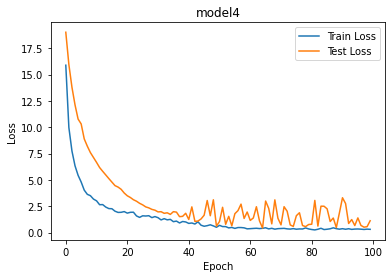

333/333 [==============================] - 2s 2ms/step
SMAPE: 3.46629027


In [17]:
#Another LSTM with different settings

model4 = Sequential()
model4.add(LSTM(64, input_shape=(1,20), return_sequences=True))
model4.add(Dropout(0.2, input_shape=(1,20)))
model4.add(LSTM(64))
model4.add(Dropout(0.2, input_shape=(1,20)))
model4.add(Dense(1))

model4.compile(loss='mean_squared_error', optimizer='adam')
history4 = model4.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))
# Plot the train and test loss over epochs
plt.plot(history4.history['loss'], label='Train Loss')
plt.plot(history4.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('model4')
plt.legend()
plt.show()

y_pred_LSTM4 = model4.predict(X_test)
y_pred_LSTM4 = y_pred_LSTM4.reshape(y_pred_LSTM4.shape[0])
print("SMAPE: %.8f" % smape(y_test, y_pred_LSTM4))


In [8]:
import joblib
model_filename = 'hist_gradient_model.joblib'
joblib.dump(gbr, model_filename)

# Load the model from the file
loaded_model = joblib.load(model_filename)